# Mohammad Amin Nazerzadeh: mohammad.nazerzadeh@studio.unibo.it
# Davide Baldelli: davide.baldelli4@studio.unibo.it
# Mohammad Reza Ghasemi Madani: mohammadreza.ghasemi@studio.unibo.it 

# Final Model

In this notebook, we are going to stack our three submodules (Retriever, Extractor, Generatior) and create a final pipeline. 

Furthermore, we are going to evaluate our model with the evaluation script taken from the [HotPotQA website](https://hotpotqa.github.io/). 

## Install dependencies

In [ ]:
!pip install transformers datasets ujson

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 KB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 3.2 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


## Mount Drive

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
drive_path = "/content/gdrive/MyDrive/" 

## Logging in HF

In [ ]:
from huggingface_hub import notebook_login, create_repo

notebook_login()

## Setting device

In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else ("cpu")

## Downloading HotPotQA

In [ ]:
from datasets import load_dataset

hpqa = load_dataset("hotpot_qa", "distractor")

Generating train split:   0%|          | 0/90447 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/7405 [00:00<?, ? examples/s]

Dataset hotpot_qa downloaded and prepared to /root/.cache/huggingface/datasets/hotpot_qa/distractor/1.0.0/133b9501f892e5193babbad937bee3b4899deb4691ef4d791e6ac0111c875bb5. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
hpqa

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'answer', 'type', 'level', 'supporting_facts', 'context'],
        num_rows: 90447
    })
    validation: Dataset({
        features: ['id', 'question', 'answer', 'type', 'level', 'supporting_facts', 'context'],
        num_rows: 7405
    })
})

In [ ]:
test_data = hpqa["validation"]

## Evaluation function

The following functions have been takne directly by the evaluation script of HotPotQA. Only the `eval` function has been modified so to take as input two dicctionaries instead of two file names. 


Call `eval(prediction_file, gold_file)` for evaluating. 

The structure of the files is specified in the *Create Prediction and Gold files* section. 

In [ ]:
import sys
import ujson as json
import re
import string
from collections import Counter
import pickle

def normalize_answer(s):

    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def f1_score(prediction, ground_truth):
    normalized_prediction = normalize_answer(prediction)
    normalized_ground_truth = normalize_answer(ground_truth)

    ZERO_METRIC = (0, 0, 0)

    if normalized_prediction in ['yes', 'no', 'noanswer'] and normalized_prediction != normalized_ground_truth:
        return ZERO_METRIC
    if normalized_ground_truth in ['yes', 'no', 'noanswer'] and normalized_prediction != normalized_ground_truth:
        return ZERO_METRIC

    prediction_tokens = normalized_prediction.split()
    ground_truth_tokens = normalized_ground_truth.split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return ZERO_METRIC
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1, precision, recall


def exact_match_score(prediction, ground_truth):
    return (normalize_answer(prediction) == normalize_answer(ground_truth))

def update_answer(metrics, prediction, gold):
    em = exact_match_score(prediction, gold)
    f1, prec, recall = f1_score(prediction, gold)
    metrics['em'] += float(em)
    metrics['f1'] += f1
    metrics['prec'] += prec
    metrics['recall'] += recall
    return em, prec, recall

def update_sp(metrics, prediction, gold):
    cur_sp_pred = set(map(tuple, prediction))
    gold_sp_pred = set(map(tuple, gold))
    tp, fp, fn = 0, 0, 0
    for e in cur_sp_pred:
        if e in gold_sp_pred:
            tp += 1
        else:
            fp += 1
    for e in gold_sp_pred:
        if e not in cur_sp_pred:
            fn += 1
    prec = 1.0 * tp / (tp + fp) if tp + fp > 0 else 0.0
    recall = 1.0 * tp / (tp + fn) if tp + fn > 0 else 0.0
    f1 = 2 * prec * recall / (prec + recall) if prec + recall > 0 else 0.0
    em = 1.0 if fp + fn == 0 else 0.0
    metrics['sp_em'] += em
    metrics['sp_f1'] += f1
    metrics['sp_prec'] += prec
    metrics['sp_recall'] += recall
    return em, prec, recall

def eval(prediction, gold):
    #with open(prediction_file) as f:
    #    prediction = json.load(f)
    #with open(gold_file) as f:
    #    gold = json.load(f)

    metrics = {'em': 0, 'f1': 0, 'prec': 0, 'recall': 0,
        'sp_em': 0, 'sp_f1': 0, 'sp_prec': 0, 'sp_recall': 0,
        'joint_em': 0, 'joint_f1': 0, 'joint_prec': 0, 'joint_recall': 0}
    for dp in gold:
        cur_id = dp['_id']
        can_eval_joint = True
        if cur_id not in prediction['answer']:
            print('missing answer {}'.format(cur_id))
            can_eval_joint = False
        else:
            em, prec, recall = update_answer(
                metrics, prediction['answer'][cur_id], dp['answer'])
        if cur_id not in prediction['sp']:
            print('missing sp fact {}'.format(cur_id))
            can_eval_joint = False
        else:
            sp_em, sp_prec, sp_recall = update_sp(
                metrics, prediction['sp'][cur_id], dp['supporting_facts'])

        if can_eval_joint:
            joint_prec = prec * sp_prec
            joint_recall = recall * sp_recall
            if joint_prec + joint_recall > 0:
                joint_f1 = 2 * joint_prec * joint_recall / (joint_prec + joint_recall)
            else:
                joint_f1 = 0.
            joint_em = em * sp_em

            metrics['joint_em'] += joint_em
            metrics['joint_f1'] += joint_f1
            metrics['joint_prec'] += joint_prec
            metrics['joint_recall'] += joint_recall

    N = len(gold)
    for k in metrics.keys():
        metrics[k] /= N


    return metrics

## Preprocessing functions

#### Retriever

In [ ]:
def prepare_features_ret(examples, tokenizer):
  final = {'input_ids':[], 'attention_mask':[], 'labels':[], 'token_type_ids':[]}
  for i in range(len(examples['id'])):
    for j in range(len(examples['context'][i]['sentences'])):
      tokenized = tokenizer(examples['question'][i], ''.join(examples['context'][i]['sentences'][j]), padding="max_length", max_length=512, truncation='only_second')
      if examples['context'][i]['title'][j] in examples['supporting_facts'][i]['title']:
        tokenized['labels'] = 1
      else:
        tokenized['labels'] = 0
      for key in tokenized.keys():
        final[key].append(tokenized[key])
  return final

#### Sentence Extractor

In [ ]:
def prepare_features_ext(examples):
    final = {'input_ids': [], 'attention_mask': [], 'labels': [], 'token_type_ids': []}
    
    for i in range(len(examples['id'])):
        query = examples['question'][i]
        contexts = examples['context'][i]
        facts = examples['supporting_facts'][i]

        # initializing a dict to save titles with corresponding supporting facts
        labels = {value:list() for value in contexts['title']}
        for t, title in enumerate(facts['title']):
            labels[title].append(facts['sent_id'][t])

        # Generating samples in proper format 
        for t, title in enumerate(contexts['title']):
          if title in facts['title']:
            for s, sentence in enumerate(contexts['sentences'][t]):
              # tokenizing query concatenated with sentences
              tokenized = sen_tokenizer(query, sentence, padding="max_length", max_length=64, truncation=True)
              # Set the senetnce label to 1 if it's in facts O.W set to 0
              tokenized['labels'] = 1 if s in labels[title] else 0

              for key in tokenized.keys():
                  final[key].append(tokenized[key])
    return final

#### Reader

In [ ]:
encoder_max_length = 512
decoder_max_length = 128

def prepare_features_gen(examples):
    # Tokenize our examples with truncation and padding
    
    # Create inputs in the proper format
    inputs = [f"question: {question} context: {context}" for question, context in
              zip(examples["question"], examples["context"])]

    tokenized_examples = gen_tokenizer(
        inputs,
        return_tensors = 'pt',
        truncation= True,
        max_length=encoder_max_length,
        padding="max_length",
    )

    
    tokenized_answers = gen_tokenizer(list(examples["answer"]),
                                  return_tensors = 'pt',
                                  max_length=decoder_max_length,
                                  padding="max_length",
                                  truncation = True)
    

    labels = tokenized_answers["input_ids"]

    # We have to substitute the padding token id with -100 in order to allow 
    # the loss function to ignore the padding
    padding_mask = labels == gen_tokenizer.pad_token_id
    padding_mask = padding_mask.type(torch.int32)
    padding_mask = padding_mask*(-100 - gen_tokenizer.pad_token_id)
    tokenized_examples["labels"] = labels + padding_mask

    return tokenized_examples

# Utility function to transform a label into a tokenization that can be decoded by the tokenizer
# i.e. substitute -100 with the padding token

def label_to_tok(labels):
  padding_mask = labels == reader_tokenizer.pad_token_id
  padding_mask = padding_mask.type(torch.int32)
  padding_mask = padding_mask*(100 + reader_tokenizer.pad_token_id)
  return labels + padding_mask

## Import models

Here we are going to import the three different Models and Tokenizers from our Hugging Face Hub. In particular: 
* **Retriever**: <br> 
  Model class: AutoModelForSequenceClassifications <br>
  Checkpoint: 'nlpproject2023/small-bert'
* **Extractor**: <br>
  Model class:  AutoModelForSequenceClassifications <br>
  Checkpoint: 'nlpproject2023/bert-base-uncased'
* **Generator**:  <br>
  Model class:  AutoModelForSeq2SeqLM <br>
  Checkpoint: 'nlpproject2023/bert-base-uncased'



#### Retriever

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

ret_checkpoint = 'nlpproject2023/small-bert'

ret_tokenizer = AutoTokenizer.from_pretrained(ret_checkpoint)
retriever = AutoModelForSequenceClassification.from_pretrained(ret_checkpoint)

#### Extractor

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

ext_checkpoint = 'nlpproject2023/bert-base-uncased'

ext_tokenizer = AutoTokenizer.from_pretrained(ext_checkpoint)
extractor = AutoModelForSequenceClassification.from_pretrained(ext_checkpoint)

#### Generator



In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

gen_checkpoint = "nlpproject2023/T5-small_SQuAD_HotPotQA_reader"

gen_tokenizer = AutoTokenizer.from_pretrained(gen_checkpoint)
generator = AutoModelForSeq2SeqLM.from_pretrained(gen_checkpoint).to(device)


## Create Prediction and Gold files

In this section we are going to compute our model's predcitions on the test set and store the results as indicated in the HotPotQA website. 

The prediction file should have this structure



```
prediction file = {
  "answer": {
    "sample_id": "sample answer"
  }, 
  "sp": {
    "sample_id": [
      ["title", sent_id]      
    ]
  }
}
```

The gold file should have this one: 


```
gold file = [{
  "_id": "sample id", 
  "answer": "sample answer", 
  "supporting_facts": [
      ["title", sent_id]      
    ] 
}]
```

### Creating gold file

In [ ]:
from tqdm import tqdm 

gold_file = []

for row in tqdm(hpqa["validation"]):
  id = row["id"]
  answer = row["answer"]
  supporting_facts = row["supporting_facts"]
  sp = [[title, sent_id] for title, sent_id 
        in zip(supporting_facts["title"], supporting_facts["sent_id"])]

  gold_file.append({"_id": id, 
                    "answer": answer, 
                    "supporting_facts": sp})


100%|██████████| 7405/7405 [00:01<00:00, 6247.11it/s]


Let's see a sample

In [ ]:
gold_file[0]

{'_id': '5a8b57f25542995d1e6f1371',
 'answer': 'yes',
 'supporting_facts': [['Scott Derrickson', 0], ['Ed Wood', 0]]}

### Computing predictions and creating prediction file

We are going to store intermediate predictions in HF `Dataset` datasets.

#### Retriever Prediction

In [ ]:
import pandas as pd
from datasets import Dataset
from tqdm import tqdm

# Initialize Dataset of Retrieved Paragraphs 
ret_pred = Dataset.from_pandas(pd.DataFrame(columns = ['id', 'question', 'context']), preserve_index=False)

retriever.eval()
with torch.no_grad():

  # Moving the model to GPU
  retriever.to(device)
  
  for i in tqdm(range(len(test_data))):
    row = {}
    # Preprocess the inputs
    batch = Dataset.from_dict(prepare_features_ret(test_data[i:i+1], ret_tokenizer))
    batch.set_format(type='torch', columns=["input_ids", "attention_mask", "token_type_ids"])

    title = []
    sentences = []
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    token_type_ids = batch["token_type_ids"].to(device)

    # Compute predictions
    preds = torch.argmax(retriever(input_ids = input_ids, 
                                      attention_mask = attention_mask, 
                                      token_type_ids = token_type_ids).logits, axis = 1)
    
    # Create predictions in proper format
    for j , pred in enumerate(preds):
      if pred == 1:
        title.append(test_data[i]['context']['title'][j])
        sentences.append(test_data[i]['context']['sentences'][j])

    row['id'] = test_data[i]['id']
    row['question'] = test_data[i]['question']
    row['context'] = {'title':title, 'sentences': sentences}
    ret_pred = ret_pred.add_item(row)

100%|██████████| 7405/7405 [14:22<00:00,  8.58it/s]


In [ ]:
ret_pred_path = drive_path + "ret_pred"
ret_pred.save_to_disk(ret_pred_path)

Saving the dataset (0/1 shards):   0%|          | 0/7405 [00:00<?, ? examples/s]

In [ ]:
ret_pred

Dataset({
    features: ['id', 'question', 'context'],
    num_rows: 7405
})

Here it is how the retrieved paragraphs looks like. 

In [ ]:
ret_pred["context"][0]

{'sentences': [['Scott Derrickson (born July 16, 1966) is an American director, screenwriter and producer.',
   ' He lives in Los Angeles, California.',
   ' He is best known for directing horror films such as "Sinister", "The Exorcism of Emily Rose", and "Deliver Us From Evil", as well as the 2016 Marvel Cinematic Universe installment, "Doctor Strange."'],
  ['Edward Davis Wood Jr. (October 10, 1924 – December 10, 1978) was an American filmmaker, actor, writer, producer, and director.']],
 'title': ['Scott Derrickson', 'Ed Wood']}

#### Sentence Extractor Prediction

In [ ]:
import numpy as np
from tqdm import tqdm
from datasets import Dataset

# Initialize Dataset of Retrieved Sentences
ext_pred = Dataset.from_pandas(pd.DataFrame(columns = ['id', 'question', 'facts']), preserve_index=False)

extractor.eval()
with torch.no_grad():

  # Moving the model to GPU
  extractor.to(device)

  for examples in tqdm(ret_pred):

      row = {}

      final = {'input_ids': [], 
              'attention_mask': [], 
              'token_type_ids': []}
      
      query = examples['question']
      contexts = examples['context']

      # keeping empty samples as they are
      if len(contexts['title'])==0:
        row['id'] = examples['id']
        row['question'] = query
        row['facts'] = []

        ext_pred = ext_pred.add_item(row)
        continue

      context_sentences = []
      
      # Generating samples in proper format 
      for t, title in enumerate(contexts['title']):
        for s, sentence in enumerate(contexts['sentences'][t]):
          context_sentences.append(sentence)
          tokenized = ext_tokenizer(query, 
                                    sentence, 
                                    padding="max_length", 
                                    max_length=64, 
                                    truncation=True)

          for key in tokenized.keys():
              final[key].append(tokenized[key])

      x = Dataset.from_dict(final)
      x.set_format(type='torch', columns=["input_ids", "attention_mask", "token_type_ids"])

      input_ids = x["input_ids"].to(device)
      attention_mask = x["attention_mask"].to(device)
      token_type_ids = x["token_type_ids"].to(device)

      # Computing predictions
      predictions = torch.argmax(extractor(input_ids = input_ids, 
                                              attention_mask = attention_mask, 
                                              token_type_ids = 
                                              token_type_ids).logits, axis = 1)
    
      # predictions, labels, _ = trainer.predict(x) 
          
      sp_sentences = []
      predictions = predictions.cpu().detach().numpy()
      sp_idx = np.nonzero(predictions)[0].tolist()
      for i in sp_idx:
        sp_sentences.append(context_sentences[i])

      row['id'] = examples['id']
      row['question'] = query
      row['facts'] = sp_sentences

      ext_pred = ext_pred.add_item(row)

100%|██████████| 7405/7405 [11:02<00:00, 11.18it/s]


In [ ]:
ext_pred_path = drive_path + "ext_pred"
ext_pred.save_to_disk(ext_pred_path)

Saving the dataset (0/1 shards):   0%|          | 0/7405 [00:00<?, ? examples/s]

In [ ]:
ext_pred

Dataset({
    features: ['id', 'question', 'facts'],
    num_rows: 7405
})

Let's see how retrieved sentences look like. 

In [ ]:
ext_pred["facts"][0]

['Scott Derrickson (born July 16, 1966) is an American director, screenwriter and producer.',
 'Edward Davis Wood Jr. (October 10, 1924 – December 10, 1978) was an American filmmaker, actor, writer, producer, and director.']

Create the supporting facts prediction file.

In [ ]:
sps = {}

for r, row in enumerate(test_data):
  id = row["id"]

  assert id == ext_pred[r]['id']

  sp = []
  for fact in ext_pred[r]['facts']:
    for g, gold_facts in enumerate(row['context']['sentences']):
      if fact in gold_facts:
        title = row['context']['title'][g]
        sent_id = gold_facts.index(fact)
        sp.append([title, sent_id])

  sps[id] = sp

#### Reader prediction

In [ ]:
answers = {}

# Initializing prediction Dataset
gen_pred = Dataset.from_pandas(pd.DataFrame(columns = ['id', 'question', 'answer']), preserve_index=False)


with torch.no_grad():

  # Moving the model to GPU
  generator.to(device)
  generator.eval()

  for row in tqdm(ext_pred):

      id = row["id"]
      question = row["question"]
      context = " ".join(row["facts"])

      input = f"question: {question} context: {context}"

      tokenized_input = gen_tokenizer(
          input,
          return_tensors = 'pt',
          truncation= True,
          max_length = gen_tokenizer.model_max_length,
          padding="max_length",
      ).to(device)

      # Computing the prediction
      output = generator.generate(**tokenized_input, 
                              num_beams = 3,
                              top_k = 10,
                              do_sample = True,
                              max_length = 15)
      
      answer = gen_tokenizer.decode(output[0], 
                                       skip_special_tokens = True)

      # Updating the dataset
      row = {"id": id, 
             "question": question, 
             "answer": answer}

      # Updating the prediciton_file
      gen_pred = gen_pred.add_item(row)
      
      answers[id] = answer

100%|██████████| 7405/7405 [16:52<00:00,  7.31it/s]


In [ ]:
gen_pred_path = drive_path + "gen_pred"
gen_pred.save_to_disk(gen_pred_path)

Saving the dataset (0/1 shards):   0%|          | 0/7405 [00:00<?, ? examples/s]

In [ ]:
gen_pred

Dataset({
    features: ['id', 'question', 'answer'],
    num_rows: 7405
})

In [ ]:
gen_pred[0]

{'id': '5a8b57f25542995d1e6f1371',
 'question': 'Were Scott Derrickson and Ed Wood of the same nationality?',
 'answer': 'no'}

#### Putting everything together

Let's create the final prediction file and evaluate our model. 

In [ ]:
prediction_file = {"answer": answers, 
                   "sp": sps}

## Under the Hood

Let's see what happens under the hood.
Given a sample question and set of paragraphs: 

In [ ]:
from pprint import pprint

sample_idx = np.random.randint(len(test_data))
row = test_data[sample_idx]
question = row["question"]
context = row["context"]

print(f"QUESTION: {question}")
print(f"\nCONTEXT: ")
pprint(context)

QUESTION: Which airline partners with Gogo Inflight Internet and opened in 1984?

CONTEXT: 
{'sentences': [['Miles & More is the largest traveler loyalty programme in '
                'Europe with 25 million members as of March 2014.',
                ' It offers rewards to passengers of the Star Alliance '
                'travelling on certain types of tickets.',
                ' The programme was launched by Lufthansa (LH) in 1993 and has '
                'about 40 airline partners, including the 28 airlines of the '
                'Star Alliance.',
                ' The programme enables its members to earn and redeem '
                'frequent flyer miles on all of the fully integrated airlines, '
                'all Star Alliance members as well as several other partner '
                'airlines.',
                ' Furthermore, there are more than 270 non-aviation companies '
                'affiliated with the programme.',
                ' These include partners from 

The Retriever has selected the following paragraphs: 

In [ ]:
pprint(ret_pred[sample_idx]["context"])

{'sentences': [['Virgin Atlantic, a trading name of Virgin Atlantic Airways '
                'Limited and Virgin Atlantic International Limited, is a '
                'British airline with its head office in Crawley, United '
                'Kingdom.',
                ' The airline was established in 1984 as British Atlantic '
                'Airways, and was originally planned by its co-founders '
                'Randolph Fields and Alan Hellary to fly between London and '
                'the Falkland Islands.',
                ' Soon after changing the name to Virgin Atlantic Airways, '
                'Fields sold his shares in the company after disagreements '
                'with Sir Richard Branson over the management of the company.',
                ' The maiden flight from London Gatwick to Newark Liberty '
                'International Airport took place on 22 June 1984.'],
               ['Gogo Inc. is a provider of in-flight broadband Internet '
                'ser

The Extractor has selected the following supporting facts: 

In [ ]:
pprint(ext_pred[sample_idx]["facts"])

[' The airline was established in 1984 as British Atlantic Airways, and was '
 'originally planned by its co-founders Randolph Fields and Alan Hellary to '
 'fly between London and the Falkland Islands.',
 ' 17 airlines partner with Gogo to provide in-flight WiFi, including British '
 'Airways, Aer Lingus, Iberia, Gol linhas aereas, Beijing Capital, Aeromexico, '
 'American Airlines, Air Canada, Alaska Airlines, Delta Air Lines, Japan '
 'Airlines, JTA, United Airlines, Hainan Airlines, Virgin America, Vietnam '
 'Airlines and Virgin Atlantic.']


And the Generator has provided the following answer: 

In [ ]:
print(gen_pred[sample_idx]["answer"])

British Atlantic Airways


## Evaluation

#### Creating results file

We are going to create a results DataFrame to evaluate the performances. It will contain the following columns for each qa pair: "id", "sp_f1", "sp_em", "ans_f1", "ans_em", "type". 

In [ ]:
from datasets import load_from_disk

ret_pred = load_from_disk(drive_path + "ret_pred")
ext_pred = load_from_disk(drive_path + "ext_pred")
gen_pred = load_from_disk(drive_path + "gen_pred")

In [ ]:
from tqdm import tqdm
import pandas as pd

results = []
columns = ["id", "sp_f1", "sp_em", "ans_f1", "ans_em", "type"]

err_ids = []
for i in tqdm(range(len(test_data))):

  gold_row = test_data[i]
  id = gold_row["id"]
  q_type = gold_row["type"]

  assert id == ext_pred[i]["id"] and id == gen_pred[i]["id"]

  gold_ans = gold_row["answer"]
  pred_facts = ext_pred[i]["facts"] 
  pred_ans = gen_pred[i]["answer"]

  sent_ids = gold_row["supporting_facts"]["sent_id"] 
  gold_titles = gold_row["supporting_facts"]["title"]
  titles = gold_row["context"]["title"]
  gold_ids = [titles.index(gold_title) for gold_title in gold_titles]
  
  try: 
    gold_facts = [gold_row["context"]["sentences"][gold_id][sent_id] for gold_id, sent_id in zip(gold_ids, sent_ids)]
  except: 
    err_ids.append(i)
    continue

  # Computing metrics for supporting facts
  cur_sp_pred = set(pred_facts)
  gold_sp_pred = set(gold_facts)
  tp, fp, fn = 0, 0, 0
  for e in cur_sp_pred:
      if e in gold_sp_pred:
          tp += 1
      else:
          fp += 1
  for e in gold_sp_pred:
      if e not in cur_sp_pred:
          fn += 1
  prec = 1.0 * tp / (tp + fp) if tp + fp > 0 else 0.0
  recall = 1.0 * tp / (tp + fn) if tp + fn > 0 else 0.0
  sp_f1 = 2 * prec * recall / (prec + recall) if prec + recall > 0 else 0.0
  sp_em = 1.0 if fp + fn == 0 else 0.0

  # Computing metrics for answers
  ans_f1 = f1_score(pred_ans, gold_ans)[0]
  ans_em = float(exact_match_score(pred_ans, gold_ans))
  
  results.append([id, sp_f1, sp_em, ans_f1, ans_em, q_type])

results = pd.DataFrame(results, columns = columns)

100%|██████████| 7405/7405 [00:07<00:00, 974.23it/s] 


In [ ]:
print(f"The row corresponding to the index {err_ids[0]} was badly formatted, we have discarded it")

The row corresponding to the index 5059 was badly formatted, we have discarded it


Let's save the results on the Drive and download them again

In [ ]:
res_path = "/content/gdrive/MyDrive/results.csv"
results.to_csv(res_path)

In [ ]:
import pandas as pd
res_path = "/content/gdrive/MyDrive/results.csv"
results = pd.read_csv(res_path, index_col = 0)

In [ ]:
results

,id,sp_f1,sp_em,ans_f1,ans_em,type
0,5a8b57f25542995d1e6f1371,1.000000,1.0,0.000000,0.0,comparison
1,5a8c7595554299585d9e36b6,1.000000,1.0,0.000000,0.0,bridge
2,5a85ea095542994775f606a8,0.571429,0.0,1.000000,1.0,bridge
3,5adbf0a255429947ff17385a,1.000000,1.0,1.000000,1.0,comparison
4,5a8e3ea95542995a26add48d,1.000000,1.0,0.571429,0.0,bridge
...,...,...,...,...,...,...
7399,5ab92307554299753720f72d,1.000000,1.0,1.000000,1.0,bridge
7400,5abba3b1554299642a094aed,0.800000,0.0,0.000000,0.0,comparison
7401,5a8173fa554299260e20a28e,0.800000,0.0,1.000000,1.0,comparison
7402,5a8caf1d554299585d9e3720,1.000000,1.0,1.000000,1.0,comparison


#### Performance on different question type

Lets see teh different performances on different question types.

In [ ]:
for q_type in ["bridge", "comparison"]:
  print(f"############# {q_type.upper()} #############")
  sub_res = results[results["type"] == q_type]
  for m in  ["sp_f1", "sp_em", "ans_f1", "ans_em"]:
    metric = sub_res[m].mean()
    print(f"{m}: {metric}")

############# BRIDGE #############
sp_f1: 0.7140902594874621
sp_em: 0.2773364880851783
ans_f1: 0.6165706898995762
ans_em: 0.478113909075545
############# COMPARISON #############
sp_f1: 0.8804870314621491
sp_em: 0.6301277740416947
ans_f1: 0.5622374184686152
ans_em: 0.503698722259583


#### Answer | Supporing facts - Performance

We want to see how the different performances in retrieving the supporting facts affect the results of the total model. 

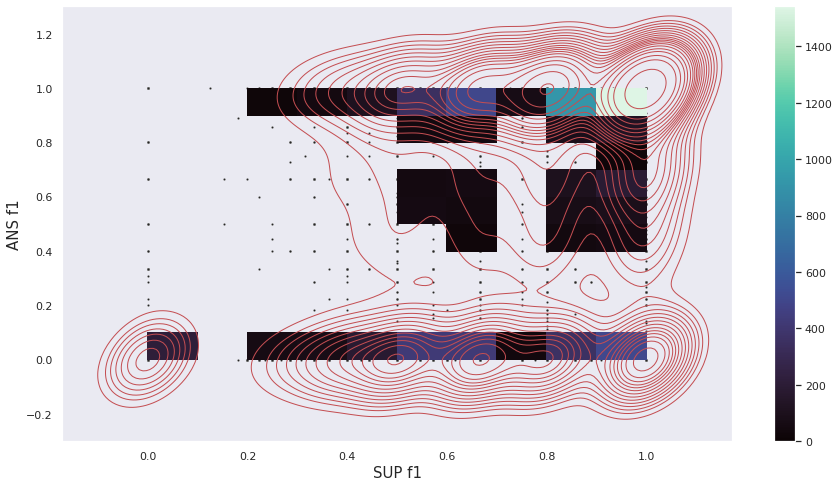

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="dark")
f, ax = plt.subplots(figsize=(15, 8))
sns.scatterplot(x=results['sp_f1'], y=results['ans_f1'], s=5, color=".15")
sns.histplot(x=results['sp_f1'], y=results['ans_f1'], bins=10, pthresh=.05, cmap="mako", cbar=True)
sns.kdeplot(x=results['sp_f1'], y=results['ans_f1'], levels=20, color="r", linewidths=1)

ax.set_xlabel("SUP f1", size = 15)
ax.set_ylabel("ANS f1", size = 15)

plt.show()



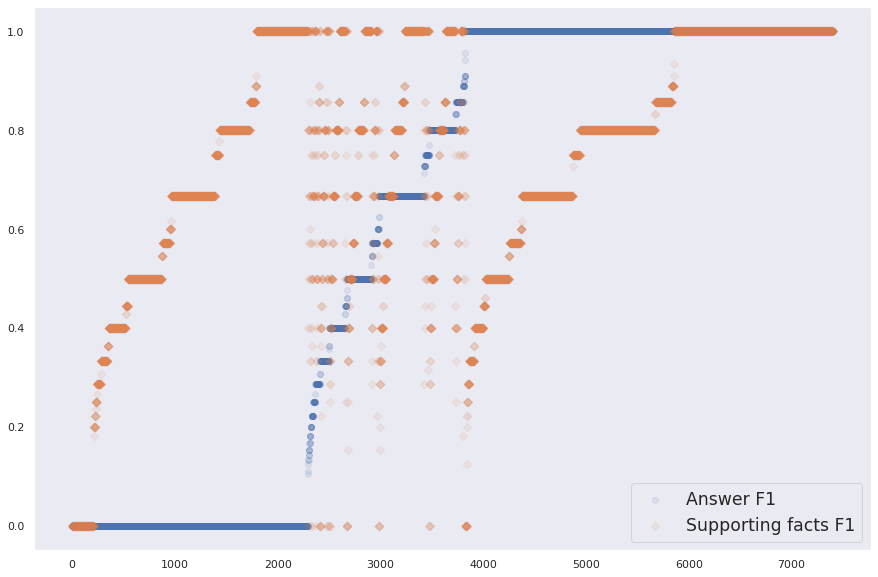

In [ ]:
import matplotlib.pyplot as plt

ans_f1 = results.sort_values(["ans_f1", "sp_f1"])["ans_f1"]
sp_f1 = results.sort_values(["ans_f1", "sp_f1"])["sp_f1"]

plt.figure(figsize = (15,10))

plt.scatter(range(len(results)), ans_f1, label="Answer F1", alpha = .1)
plt.scatter(range(len(results)), sp_f1, label = "Supporting facts F1", 
            marker = 'D', alpha = .1)
plt.legend(fontsize = "x-large")

plt.show()

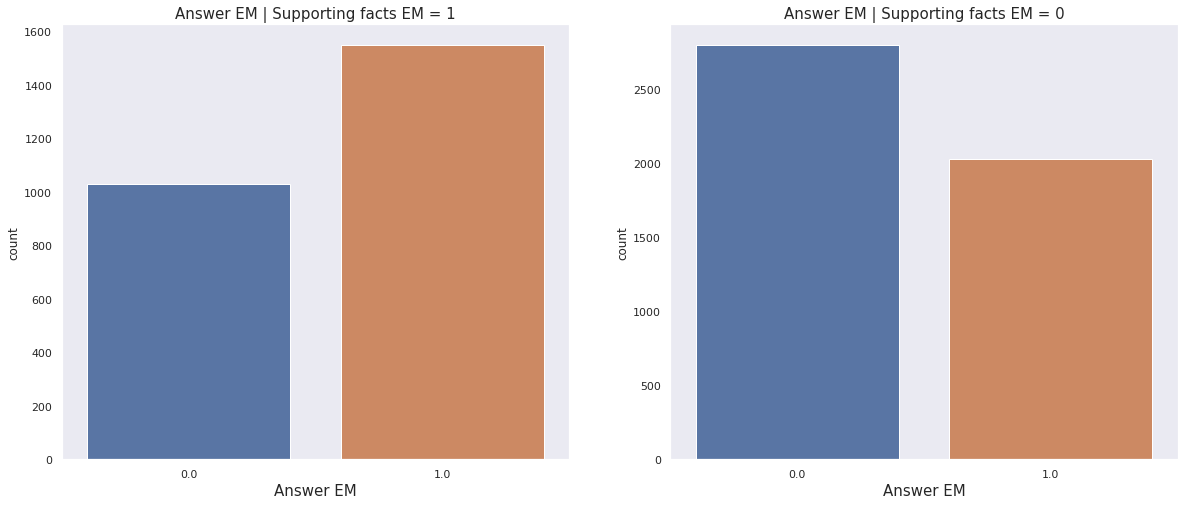

In [ ]:
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize = (20, 8))

sns.countplot(x = results[results["sp_em"] == 1]["ans_em"], ax = axs[0])
axs[0].set_title("Answer EM | Supporting facts EM = 1", size = 15)
axs[0].set_xlabel("Answer EM", size = 15)
sns.countplot(x = results[results["sp_em"] == 0]["ans_em"], ax = axs[1])
axs[1].set_title("Answer EM | Supporting facts EM = 0", size = 15)
axs[1].set_xlabel("Answer EM", size = 15)

plt.show()

Let's print some sample for which the retrieved sentences were perfect, but the f1 of the answer is zero. 

In [ ]:
gen_pred_df = pd.DataFrame(gen_pred)
test_df = pd.DataFrame(test_data)
bad_ans = gen_pred_df.loc[gen_pred_df["id"].isin(results[(results["sp_em"] == 1) & (results["ans_f1"] == 0)]["id"])]

In [ ]:
for i in range(10):

    idx = np.random.randint(len(bad_ans))
    row = bad_ans.iloc[idx]
    id = row["id"]
    question = row["question"]
    pred_answer = row["answer"]
    gold_row = test_df[test_df["id"] == id]
    gold_answer = gold_row["answer"].item()
    q_type = gold_row["type"].item()

    titles = gold_row["context"].item()["title"]
    gold_titles = gold_row["supporting_facts"].item()["title"]
    gold_ids = [titles.index(gold_title) for gold_title in gold_titles]
    sent_ids = gold_row["supporting_facts"].item()["sent_id"] 
    gold_sentences = [gold_row["context"].item()["sentences"][gold_id][sent_id] for gold_id, sent_id in zip(gold_ids, sent_ids)]
    context = " ".join(gold_sentences)

    print(f"TYPE: {q_type}")
    print(f"QUESTION: {question}")
    print(f"CONTEXT: {context}")
    print(f"PRED ANSWER: {pred_answer}")
    print(f"GOLD ANSWER: {gold_answer}")
    print("########################################")
    


TYPE: bridge
QUESTION: Who was born first, Liam Cunningham or Michael Fassbender?
CONTEXT: Liam Cunningham (born 2 June 1961) is an Irish stage and screen actor. Michael Fassbender (born 2 April 1977) is an Irish actor.
PRED ANSWER: Michael Fassbender
GOLD ANSWER: Liam Cunningham
########################################
TYPE: bridge
QUESTION: Dean Mills Reservoir is on the slopes of the hill located in what town?
CONTEXT: Dean Mills Reservoir is a small water reservoir to the north of the town of Bolton, Greater Manchester located high on the slopes of Winter Hill.  It is located on Rivington Moor, Chorley and is 1496 ft high.
PRED ANSWER: Bolton, Greater Manchester
GOLD ANSWER: Rivington Moor
########################################
TYPE: bridge
QUESTION: Which actress is "Beyond Rangoon" was also in "True Romance" and "Ed Wood?"
CONTEXT: Beyond Rangoon is a 1995 drama film directed by John Boorman about Laura Bowman (played by Patricia Arquette), an American tourist who vacations in 

#### Final Evaluation

We are going to run the final evaluation function and print the results

In [ ]:
evaluation = eval(prediction_file, gold_file)

print("###### ANS ######")
print(f"F1: {evaluation['f1']}")
print(f"EM: {evaluation['em']}")
print("###### SUP ######")
print(f"F1: {evaluation['sp_f1']}")
print(f"EM: {evaluation['sp_em']}")
print("##### JOINT #####")
print(f"F1: {evaluation['joint_f1']}")
print(f"EM: {evaluation['joint_em']}")

###### ANS ######
F1: 0.6055767472516718
EM: 0.48318703578663064
###### SUP ######
F1: 0.7467584802390042
EM: 0.3474679270762998
##### JOINT #####
F1: 0.4891079560590621
EM: 0.2086428089128967


## Final Pipeline

In this section we are going to create a wrapper function that takes as input a dicitonary formatted as the datasets, namely with a "id", "question" and "context" keys, properly structured, and returns as output a Dataset with "id", "question", "supoprting_facts", and "answer" columns. 

In [ ]:
from datasets import Dataset
import pandas as pd
from tqdm import tqdm

import numpy as np
def pipeline(input):
    
    input = Dataset.from_dict(input)

    with torch.no_grad(): 

    ###############################
    ##### PARAGRAPH SELECTOR ######
    ###############################

      par_pred = Dataset.from_pandas(pd.DataFrame(columns = ['id', 'question', 'context']), preserve_index=False)

      retriever.eval()

      # Moving the model to GPU
      retriever.to(device)
      
      for i in range(len(input)):
        row = {}
        # Preprocess the inputs
        examples = input[i:i+1]

        final = {'input_ids':[], 'attention_mask':[], 'token_type_ids':[]}
        for i in range(len(examples['id'])):
          for j in range(len(examples['context'][i]['sentences'])):
            tokenized = ret_tokenizer(examples['question'][i], ''.join(examples['context'][i]['sentences'][j]), padding="max_length", max_length=512, truncation='only_second')
            for key in tokenized.keys():
              final[key].append(tokenized[key])

        batch = Dataset.from_dict(final)
        batch.set_format(type='torch', columns=["input_ids", "attention_mask", "token_type_ids"])

        title = []
        sentences = []
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)

        # Compute predictions
        preds = torch.argmax(retriever(input_ids = input_ids, 
                                          attention_mask = attention_mask, 
                                          token_type_ids = token_type_ids).logits, axis = 1)
        
        # Create predictions in proper format
        for j , pred in enumerate(preds):
          if pred == 1:
            title.append(input[i]['context']['title'][j])
            sentences.append(input[i]['context']['sentences'][j])

        row['id'] = input[i]['id']
        row['question'] = input[i]['question']
        row['context'] = {'title':title, 'sentences': sentences}
        par_pred = par_pred.add_item(row)
        

    ##############################
    ##### SENTENCE SELECTOR ######
    ##############################    

      # Initialize Dataset of Retrieved Sentences
      sent_pred = Dataset.from_pandas(pd.DataFrame(columns = ['id', 'question', 'facts']), preserve_index=False)

      extractor.eval()

      extractor.to(device)
      for examples in par_pred:

        row = {}

        final = {'input_ids': [], 
                'attention_mask': [], 
                'token_type_ids': []}
        
        query = examples['question']
        contexts = examples['context']

        # keeping empty samples as they are
        if len(contexts['title'])==0:
          row['id'] = examples['id']
          row['question'] = query
          row['facts'] = []

          sent_pred = sent_pred.add_item(row)
          continue

        context_sentences = []
        
        # Generating samples in proper format 
        for t, title in enumerate(contexts['title']):
          for s, sentence in enumerate(contexts['sentences'][t]):
            context_sentences.append(sentence)
            tokenized = ext_tokenizer(query, 
                                      sentence, 
                                      padding="max_length", 
                                      max_length=64, 
                                      truncation=True)

            for key in tokenized.keys():
                final[key].append(tokenized[key])

        x = Dataset.from_dict(final)
        x.set_format(type='torch', columns=["input_ids", "attention_mask", "token_type_ids"])

        input_ids = x["input_ids"].to(device)
        attention_mask = x["attention_mask"].to(device)
        token_type_ids = x["token_type_ids"].to(device)

        # Computing predictions
        predictions = torch.argmax(extractor(input_ids = input_ids, 
                                                attention_mask = attention_mask, 
                                                token_type_ids = token_type_ids).logits, axis = 1)
      
            
        sp_sentences = []
        predictions = predictions.cpu().detach().numpy()
        sp_idx = np.nonzero(predictions)[0].tolist()
        for i in sp_idx:
          sp_sentences.append(context_sentences[i])

        row['id'] = examples['id']
        row['question'] = query
        row['facts'] = sp_sentences

        sent_pred = sent_pred.add_item(row)

    ###################
    ##### READER ######
    ###################

        # Initializing prediction Dataset
        results = Dataset.from_pandas(pd.DataFrame(columns = ['id', 'question', 'supporting_facts', 'answer']), preserve_index=False)

        # Moving the model to GPU
        generator.to(device)
        generator.eval()

        for row in sent_pred:

            id = row["id"]
            question = row["question"]
            supporting_facts = row["facts"]
            context = " ".join(supporting_facts)

            input = f"question: {question} context: {context}"

            tokenized_input = gen_tokenizer(
                input,
                return_tensors = 'pt',
                truncation= True,
                max_length = gen_tokenizer.model_max_length,
                padding="max_length",
            ).to(device)

            # Computing the prediction
            output = generator.generate(**tokenized_input, 
                                    num_beams = 3,
                                    top_k = 10,
                                    do_sample = True,
                                    max_length = 15)
            
            answer = gen_tokenizer.decode(output[0], 
                                            skip_special_tokens = True)

            # Updating the dataset
            row = {"id": id, 
                    "question": question,
                    "supporting_facts": supporting_facts, 
                    "answer": answer}

            # Updating the prediciton_file
            results = results.add_item(row)
            

    return results

In [ ]:
from pprint import pprint

sample_idx = np.random.randint(len(test_data))
row = test_data[sample_idx:sample_idx+1]
res = pipeline(row)


print("OUTPUT: \n")
pprint(res[0])

print("\n")
print(f"QUESTION: {row['question'][0]}\n")
print(f"SUPPORTING FACTS:")
pprint(res[0]['supporting_facts'])
print()
print(f"PREDICTED ANSWER: {res[0]['answer']}")
print(f"GOLD ANSWER: {row['answer'][0]}")

OUTPUT: 

{'answer': 'Robert Redford',
 'id': '5a7aa07d55429941d65f2703',
 'question': 'Who directed the film in which Catherine Ann "Kate" Bosworth '
             'made her debut?',
 'supporting_facts': ['The Horse Whisperer is a 1998 American drama film '
                      'directed by and starring Robert Redford, based on the '
                      '1995 novel "The Horse Whisperer" by Nicholas Evans.',
                      ' She made her film debut in "The Horse Whisperer" '
                      '(1998) and appeared in "Remember the Titans" (2000), '
                      'before landing a lead role as a teenage surfer in the '
                      'box-office hit "Blue Crush" (2002).']}


QUESTION: Who directed the film in which Catherine Ann "Kate" Bosworth made her debut?

SUPPORTING FACTS:
['The Horse Whisperer is a 1998 American drama film directed by and starring '
 'Robert Redford, based on the 1995 novel "The Horse Whisperer" by Nicholas '
 'Evans.',
 ' She made her 